<a href="https://colab.research.google.com/github/afullhart/climateanalogs/blob/main/Colab/Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

In [2]:
!pip install rioxarray
!pip install rasterio
!pip install tifffile
!pip install imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 56.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.metrics import silhouette_samples, silhouette_score
import rasterio
import rioxarray as rx
from PIL import Image
import tifffile
import imagecodecs
import os

comf = '/content/drive/My Drive/Colab Notebooks/Analogs/Extract_Composite.tif'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

image = Image.open( '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif')
arr = np.asarray(image)
mask = arr > 0

img_array = tifffile.imread(comf)
shp = img_array.shape
new_arr = []
for i in range(shp[2]):
  image = Image.fromarray(img_array[:, :, i]).convert('L')
  arr = np.asarray(image)
  filtered_arr = arr[mask].flatten().tolist()
  new_arr.append(filtered_arr)

new_arr = np.array(new_arr).transpose()

X = new_arr

test_scores = []
test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
for n in test_cluster_sizes:

  image = Image.open(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = np.asarray(image)
  filtered_arr = arr[mask]
  filtered_labels = filtered_arr.flatten()

  cluster_labels = filtered_labels
  print(cluster_labels.shape)
  scores = []
  for rand_sample in [123, 456, 789]:
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=rand_sample)
    scores.append(silhouette_avg)

  avg_score = sum(scores)/len(scores)
  test_scores.append(avg_score)


(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)


In [10]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.metrics import silhouette_samples, silhouette_score
import rasterio
import rioxarray as rx
from PIL import Image
import tifffile
import imagecodecs
import os

comf = '/content/drive/My Drive/Colab Notebooks/Analogs/Extract_Composite.tif'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

image = Image.open( '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif')
arr = np.asarray(image)
mask = arr > 0

img_array = tifffile.imread(comf)
shp = img_array.shape
new_arr = []
for i in range(shp[2]):
  image = Image.fromarray(img_array[:, :, i]).convert('L')
  arr = np.asarray(image)
  filtered_arr = arr[mask].flatten().tolist()
  new_arr.append(filtered_arr)

new_arr = np.array(new_arr).transpose()

X = new_arr

test_scores = []
test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
for n in test_cluster_sizes:

  image = Image.open(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = np.asarray(image)
  filtered_arr = arr[mask]
  filtered_labels = filtered_arr.flatten()

  cluster_labels = filtered_labels
  print(cluster_labels.shape)

  silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=123)
  print(silhouette_avg)




(1622533,)
0.1146350935401271
(1622533,)
-0.02740084212706003
(1622533,)
-0.043005174102104436
(1622533,)
-0.0661479899554069
(1622533,)
-0.07222040806531337
(1622533,)
-0.06974748009084487
(1622533,)
-0.0808232713634742
(1622533,)
-0.07103186037281524
(1622533,)
-0.08617717793530202
(1622533,)
-0.0828597905030139


Optimal Breakpoint: 6.27
Optimal Parameters (b, m1, c1, m2, c2): [ 6.27272727e+00 -4.51957798e-02  2.47646694e-01 -1.67304212e-03
 -3.67205977e-02]


/tmp/ipython-input-1460379755.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


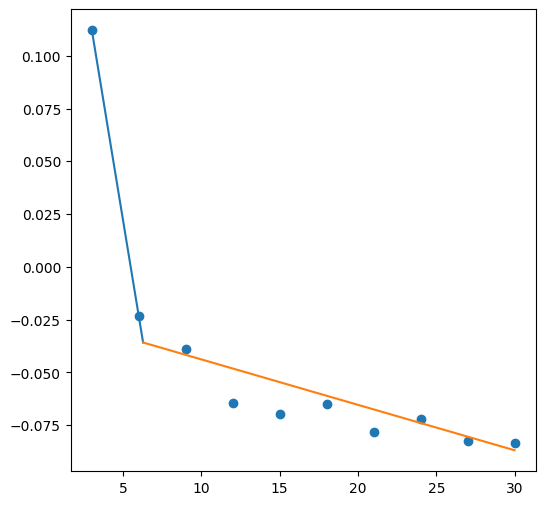

In [6]:
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b, optimal_params = find_optimal_breakpoint(x_data, y_data)

if optimal_b is not None:
  print(f"Optimal Breakpoint: {optimal_b:.2f}")
  print(f"Optimal Parameters (b, m1, c1, m2, c2): {optimal_params}")
else:
  print("Could not find an optimal breakpoint.")


# You can then use optimal_params to make predictions or visualize the fit
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), optimal_b], [optimal_params[1]*min(x_data) + optimal_params[2], optimal_params[1]*optimal_b + optimal_params[2]])
ax.plot([optimal_b, max(x_data)], [optimal_params[1]*optimal_b + optimal_params[2], optimal_params[3]*max(x_data) + optimal_params[4]])




In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.metrics import silhouette_samples, silhouette_score
import rasterio
import rioxarray as rx
from PIL import Image
import tifffile
import imagecodecs

comf = '/content/drive/My Drive/Colab Notebooks/Analogs/Extract_Composite.tif'
isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'

image = Image.open(isof)
arr = np.asarray(image)
mask = arr > 0
filtered_arr = arr[mask]
filtered_labels = filtered_arr.flatten()

img_array = tifffile.imread(comf)
shp = img_array.shape
new_arr = []
for i in range(shp[2]):
  image = Image.fromarray(img_array[:, :, i]).convert('L')
  arr = np.asarray(image)
  filtered_arr = arr[mask].flatten().tolist()
  new_arr.append(filtered_arr)

new_arr = np.array(new_arr).transpose()

X = new_arr
cluster_labels = filtered_labels

print(X.shape)
print(cluster_labels.shape)

silhouette_avg = silhouette_score(X, cluster_labels, sample_size=50000)
print(silhouette_avg)


(1622533, 23)
(1622533,)
-0.10031994805194806


In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]


print(X.size)
print(X.shape)

for n_clusters in range_n_clusters:

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    #print(cluster_labels)
    print(cluster_labels.size)
    print(cluster_labels.shape)

1000
(500, 2)
For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
500
(500,)
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
500
(500,)
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
500
(500,)
For n_clusters = 5 The average silhouette_score is : 0.561464362648773
500
(500,)
For n_clusters = 6 The average silhouette_score is : 0.4857596147013469
500
(500,)
